# Sentiment Analysis of Tweets Dataset using the following Machine Learning models
- Logistic Regression
- Random Forest Classifier
- Extra Trees Classifier
- Ada Boost Classifier
- Naive Bayes

In [17]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [2]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [3]:
# set up spark

import os
# Find the latest version of spark 3.2  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.2.3'
# spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:13 http://archive

# Transform the data

In [4]:
# load tweets_df and view
# tweets_df = pd.read_csv("Resources/Tweets.csv")


from pyspark import SparkFiles
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [5]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [6]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [7]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


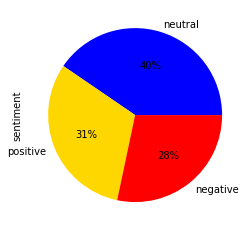

In [8]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [9]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [10]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

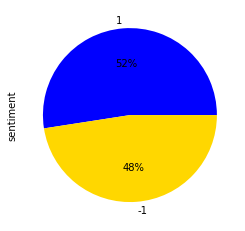

In [11]:
# visualize distribution - without neutral sentiment
tweets_no_neut.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [12]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [13]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    training_score, testing_score, recall, precision = evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)
    
    return training_score, testing_score, recall, precision

In [14]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    training_score = model.score(X_train_tfidf, y_train)
    testing_score = model.score(X_test_tfidf, y_test)
    recall = recall_score(y_test.values, model.predict(X_test_tfidf), average='macro')
    precision = precision_score(y_test.values, model.predict(X_test_tfidf), average='macro')
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))
    
    return training_score, testing_score, recall, precision

In [15]:
# create dataframe for attempts
performance_df = pd.DataFrame(columns=["Model", "Attempt Number", "Training Score", "Testing Score", "Parameters", "Recall", "Precision"])
performance_df.head()

,Model,Attempt Number,Training Score,Testing Score,Parameters,Recall,Precision


## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, model, 0)
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, model, 0)
performance_df.loc[len(performance_df.index)] = ['Logistic Regression', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Attempt 1 ----------------------------------------
Training Data Score: 0.8217370208636584
Testing Data Score: 0.6876728278270994 

[[1145  690  106]
 [ 336 2092  339]
 [  97  578 1488]]
              precision    recall  f1-score   support

          -1       0.73      0.59      0.65      1941
           0       0.62      0.76      0.68      2767
           1       0.77      0.69      0.73      2163

    accuracy                           0.69      6871
   macro avg       0.71      0.68      0.69      6871
weighted avg       0.70      0.69      0.69      6871

Attempt 2 ----------------------------------------
Training Data Score: 0.9296773142112125
Testing Data Score: 0.8699584453678807 

[[1723  244]
 [ 288 1836]]
              precision    recall  f1-score   support

          -1       0.86      0.88      0.87      1967
           1       0.88      0.86      0.87      2124

    accuracy                           0.87      4091
   macro avg       0.87      0.87      0.87      4091
w

## Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, twitter_classi, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Random Forest', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Random Forest', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

Attempt 1 ----------------------------------------
Training Data Score: 0.9976801310043668
Testing Data Score: 0.6976532654175005 

[[ 899  540  113]
 [ 258 1638  321]
 [  58  372 1298]]
              precision    recall  f1-score   support

          -1       0.74      0.58      0.65      1552
           0       0.64      0.74      0.69      2217
           1       0.75      0.75      0.75      1728

    accuracy                           0.70      5497
   macro avg       0.71      0.69      0.70      5497
weighted avg       0.70      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.99938884644767
Testing Data Score: 0.8594561564314085 

[[1345  180]
 [ 280 1468]]
              precision    recall  f1-score   support

          -1       0.83      0.88      0.85      1525
           1       0.89      0.84      0.86      1748

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
wei

## Extra Trees Classifier

In [20]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, twitter_ex, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Extreme Trees', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

Attempt 1 ----------------------------------------
Training Data Score: 0.9974981804949054
Testing Data Score: 0.7025650354738948 

[[ 973  523  115]
 [ 260 1603  313]
 [  74  350 1286]]
              precision    recall  f1-score   support

          -1       0.74      0.60      0.67      1611
           0       0.65      0.74      0.69      2176
           1       0.75      0.75      0.75      1710

    accuracy                           0.70      5497
   macro avg       0.71      0.70      0.70      5497
weighted avg       0.71      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9994652406417113
Testing Data Score: 0.8560953253895509 

[[1347  203]
 [ 268 1455]]
              precision    recall  f1-score   support

          -1       0.83      0.87      0.85      1550
           1       0.88      0.84      0.86      1723

    accuracy                           0.86      3273
   macro avg       0.86      0.86      0.86      3273
w

## Ada Boost Classifier

In [21]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df, 1, twitter_ada, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)
performance_df.loc[len(performance_df.index)] = ['Ada Boost', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

Attempt 1 ----------------------------------------
Training Data Score: 0.6565229257641921
Testing Data Score: 0.6459887211206112 

[[ 666  854  104]
 [ 175 1749  259]
 [  43  511 1136]]
              precision    recall  f1-score   support

          -1       0.75      0.41      0.53      1624
           0       0.56      0.80      0.66      2183
           1       0.76      0.67      0.71      1690

    accuracy                           0.65      5497
   macro avg       0.69      0.63      0.63      5497
weighted avg       0.68      0.65      0.64      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.8062643239113827
Testing Data Score: 0.7965169569202566 

[[1374  130]
 [ 536 1233]]
              precision    recall  f1-score   support

          -1       0.72      0.91      0.80      1504
           1       0.90      0.70      0.79      1769

    accuracy                           0.80      3273
   macro avg       0.81      0.81      0.80      3273
w

# Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_df,1,mnb,train_size=0.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 1, training_score, testing_score, 'including neutrals', recall, precision]

# create model and get performance
training_score, testing_score, recall, precision = create_model(tweets_no_neut,2,mnb,train_size=0.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 2, training_score, testing_score, 'excluding neutrals', recall, precision]

Attempt 1 ----------------------------------------
Training Data Score: 0.7945323871906841
Testing Data Score: 0.6252501364380572 

[[ 643  844   63]
 [ 163 1791  222]
 [  31  737 1003]]
              precision    recall  f1-score   support

          -1       0.77      0.41      0.54      1550
           0       0.53      0.82      0.65      2176
           1       0.78      0.57      0.66      1771

    accuracy                           0.63      5497
   macro avg       0.69      0.60      0.61      5497
weighted avg       0.68      0.63      0.62      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9394957983193277
Testing Data Score: 0.8472349526428353 

[[1268  319]
 [ 181 1505]]
              precision    recall  f1-score   support

          -1       0.88      0.80      0.84      1587
           1       0.83      0.89      0.86      1686

    accuracy                           0.85      3273
   macro avg       0.85      0.85      0.85      3273
w

# Naive Bayes using PySpark

In [23]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()
# url ="https://tweet-2022.s3.amazonaws.com/Tweets.csv"
# spark.sparkContext.addFile(url)
# spark_tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)
# tweets_df = spark.read.csv(SparkFiles.get("Tweets.csv"), sep=",", header=True)


nb_tweets_df = pd.read_csv("/content/Tweets.csv")
# tweets_df=spark_tweets_df.toPandas()
nb_tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [24]:
def nb_process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
  
    # remove urls
    tweet_wo_stop = "".join([i for i in tweet if 'http' not in i])
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = "".join(lemmed)
    
    return final_tweet
nb_tweets_df['text'] = nb_tweets_df['text'].astype('str')

# delete the unneccessary columns
nb_tweets_df = nb_tweets_df.drop(columns=["textID", "selected_text"])
nb_tweets_df=nb_tweets_df.rename(columns={'sentiment':'class'})
nb_tweets_df=nb_tweets_df[['class','text']]
nb_tweets_df['text'] = nb_tweets_df['text'].apply(lambda x: nb_process_tweets(x))


nb_opt=nb_tweets_df.loc[nb_tweets_df['class']!="neutral"]

In [25]:
pip install quinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml import Pipeline
from pyspark.sql import SQLContext
import quinn
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def create_nb(tweets_df,attempt_num,model,train_size):
    
    # Create all the features to the data set
    pos_neg_to_num = StringIndexer(inputCol='class',outputCol='label')
    tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
    stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
    hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
    idf = IDF(inputCol='hash_token', outputCol='idf_token')
    
    # Create feature vectors
    clean_up = VectorAssembler(inputCols=['idf_token', 'length'], outputCol='features')
    data_prep_pipeline = Pipeline(stages=[pos_neg_to_num, tokenizer, stopremove, hashingTF, idf, clean_up])
    sc = SparkSession.builder.getOrCreate()
    sqlContext = SQLContext(sc)
    spark_tweets = sqlContext.createDataFrame(tweets_df)


    trimmed=spark_tweets.withColumn('description',quinn.single_space(spark_tweets['text']))
    trimmed=trimmed.select('class','description')
    trimmed=trimmed.withColumnRenamed('description','text')
    trimmed=trimmed.toPandas()
    trimmed['length']=""
    for index,row in trimmed.iterrows():
      nb_tweet_length=len(row['text'])
      trimmed.loc[index,'length']=nb_tweet_length
    trimmed_spark=sqlContext.createDataFrame(trimmed)
    cleaner = data_prep_pipeline.fit(trimmed_spark)
    cleaned = cleaner.transform(trimmed_spark)

    # cleaner = data_prep_pipeline.fit(spark_tweets)
    # cleaned = cleaner.transform(spark_tweets)
    
    # Break data down into a training set and a testing set
    # training, testing = cleaned.randomSplit([0.7, 0.3])
    training, testing = cleaned.randomSplit([train_size, 1-train_size])
    predictor = nb.fit(training)
    
    test_results = predictor.transform(testing)
    acc_eval = MulticlassClassificationEvaluator(labelCol="label")
    acc = acc_eval.evaluate(test_results)
    predictionAndTarget = test_results.select("label", "prediction")

  # Get metrics

    f1 = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "f1"})
    weightedPrecision = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "weightedPrecision"})
    weightedRecall = acc_eval.evaluate(predictionAndTarget, {acc_eval.metricName: "weightedRecall"})
    auc = acc_eval.evaluate(predictionAndTarget)
    print(f"Testing Accuracy of model:  {acc}")
    print(f"Precision of model:  {weightedPrecision}")
    print(f"Recall of model: {weightedRecall}")

    return acc, weightedPrecision, weightedRecall

In [29]:
nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")

acc, weightedPrecision, weightedRecall = create_nb(nb_tweets_df,1,nb,.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 1, 0, acc, 'including neutrals', weightedRecall, weightedPrecision]

acc, weightedPrecision, weightedRecall = create_nb(nb_opt,2,nb,.8)
performance_df.loc[len(performance_df.index)] = ['Multinomial Naive Bayes', 2, 0, acc, 'excluding neutrals', weightedRecall, weightedPrecision]

/content/spark-3.2.3-bin-hadoop2.7/python/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Testing Accuracy of model:  0.5735958600422645
Precision of model:  0.5768314530592904
Recall of model: 0.573377581120944
Testing Accuracy of model:  0.7942437404652958
Precision of model:  0.7956337842812957
Recall of model: 0.7946096654275092


In [30]:
performance_df

,Model,Attempt Number,Training Score,Testing Score,Parameters,Recall,Precision
0,Logistic Regression,1,0.821737,0.687673,including neutrals,0.677963,0.706003
1,Logistic Regression,2,0.929677,0.869958,excluding neutrals,0.870180,0.869740
2,Random Forest,1,0.997680,0.697653,including neutrals,0.689749,0.710564
3,Random Forest,2,0.999389,0.859456,excluding neutrals,0.860892,0.859235
4,Extreme Trees,1,0.997498,0.702565,including neutrals,0.697564,0.714053
5,Extreme Trees,2,0.999465,0.856095,excluding neutrals,0.856745,0.855810
6,Ada Boost,1,0.656523,0.645989,including neutrals,0.627826,0.690963
7,Ada Boost,2,0.806264,0.796517,excluding neutrals,0.805284,0.811997
8,Multinomial Naive Bayes,1,0.794532,0.625250,including neutrals,0.601418,0.692695
9,Multinomial Naive Bayes,2,0.939496,0.847235,excluding neutrals,0.845819,0.850098


In [32]:
performance_df.to_csv("performance.csv")

### MatPlotLib

In [33]:
performance_neutral = performance_df[performance_df["Parameters"] == "including neutrals"]
performance_no_neutral = performance_df[performance_df["Parameters"] == "excluding neutrals"]

In [34]:
# with neutrals
labels = performance_neutral["Model"].tolist()
training = performance_neutral["Training Score"].tolist()
testing = performance_neutral["Testing Score"].tolist()

In [35]:
training = [round(x, 2) for x in training]
testing = [round(x, 2) for x in testing]

In [42]:
# import matplotlib.pyplot as plt
# import numpy as np
# x = np.arange(len(labels))
# width = 0.35

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, training, width, label='Training')
# rects2 = ax.bar(x + width/2, testing, width, label='Testing')

# ax.set_ylabel('Score')
# ax.set_xticks(x, labels)
# ax.xticks(rotation=45)
# ax.set_title('Scores of Models including Neutral Tweets')
# ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)

# plt.show()